# Project : 영화리뷰 텍스트 감성분석하기

* 자연어처리에 주로 활용되는 RNN(Recurrent Neural Network)를 이용합니다.
* 네이버 영화에서 확인할 수 있는 영화 리뷰에 대한 감성분석(sentiment analysis)를 진행합니다.

* 텍스트 데이터를 머신러닝 입출력용 수치 데이터로 변환하는 과정을 이해해봅니다.
* RNN의 특징을 이해하고 시퀀스 데이터를 다루어 봅니다.
* 1-D CNN으로도 텍스트를 처리할 수 있음을 이해해봅니다.
* IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성분류 실습을 진행합니다.

##### 텍스트 감정분석
---
* 기계학습 기반 접근법과 감성사전 기반 접근법이 있습니다.
* 기계학습 기반 접근법은 분석대상에 따라 단어의 감성점수가 달라질 수 있다는 가능성에 대응하기 힘들고, 단순한 부정 긍정을 넘아 원인이 되는 대상 속성 기반의 감성 분석이 어렵다는 단점이 있습니다.
* 라벨링 비용이 많이 드는 머신러닝 기반의 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어 처리 기법인 워드 임베딩(word embedding) 기법이 있습니다.

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
# 우리가 가진 텍스트 데이터를 숫자로 바꿔보려고 합니다.
#  위 딕셔너리 구조가 {텍스트: 인덱스} 구조여야 합니다.
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel']) # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


get_encoded_sentence 함수를 통해 다음과 같이 매핑됩니다.

* <BOS> -> 1
* i -> 3
* eat -> 6
* lunch -> 7

In [6]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)


[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


In [9]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)



In [14]:
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')


raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [15]:
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.04920233  0.03652955 -0.02593552 -0.01621646]
  [ 0.04174871  0.00174866  0.01164426 -0.03484811]
  [-0.00294353 -0.01250745  0.04445549  0.02015055]
  [-0.03172749 -0.01441004 -0.03238398 -0.01289133]
  [-0.0190694   0.03745562  0.02347305 -0.04209893]]

 [[ 0.04920233  0.03652955 -0.02593552 -0.01621646]
  [ 0.04174871  0.00174866  0.01164426 -0.03484811]
  [ 0.04746332 -0.04765651  0.03560722 -0.01535026]
  [ 0.00456096 -0.00818478  0.02490513 -0.00935759]
  [-0.0190694   0.03745562  0.02347305 -0.04209893]]

 [[ 0.04920233  0.03652955 -0.02593552 -0.01621646]
  [ 0.04866708 -0.00200545  0.02695812 -0.030786  ]
  [ 0.04174871  0.00174866  0.01164426 -0.03484811]
  [-0.00294353 -0.01250745  0.04445549  0.02015055]
  [-0.02322203 -0.01929182 -0.04023997 -0.00694089]]], shape=(3, 5, 4), dtype=float32)


### RNN 모델

In [16]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [17]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## IMDB 영화리뷰 감성분석

### (1) IMDB 데이터셋 분석

In [19]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [20]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [21]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

1654784/1641221 [==============================] - 0s 0us/step
the
1


In [22]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

In [23]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

In [24]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [25]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [26]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


### (2) 딥러닝 모델 설계와 훈련

In [27]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
__________________________

모델 훈련 전에 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋으로 사용하도록 합니다.

In [28]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [29]:
# 모델 학습 시작
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 30s 47ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5028
Epoch 2/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6930 - accuracy: 0.5181 - val_loss: 0.6932 - val_accuracy: 0.5032
Epoch 3/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6929 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.5031
Epoch 4/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6923 - accuracy: 0.5195 - val_loss: 0.6925 - val_accuracy: 0.5029
Epoch 5/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6893 - accuracy: 0.5212 - val_loss: 0.6889 - val_accuracy: 0.5155
Epoch 6/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6817 - accuracy: 0.6031 - val_loss: 0.6762 - val_accuracy: 0.6296
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6912 - accuracy: 0.5357 - val_loss: 0.6994 - val_accuracy: 0.4959
Epoch 8/20
3

학습이 끝난 모델ㄷ을 테스트셋으로 평가합니다.

In [30]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.6898 - accuracy: 0.5113
[0.6897605657577515, 0.5112800002098083]


In [31]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


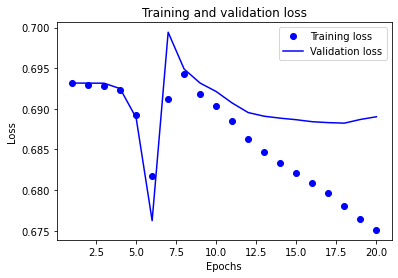

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

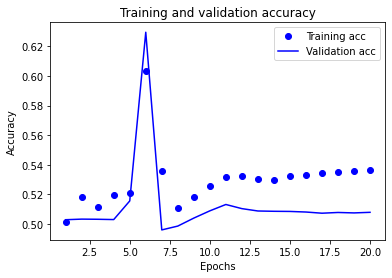

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### (3) Word2Vec의 적용

* 자연어 처리 기법으로 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩 기법이 있습니다.

* 워드 벡터 파일을 지정할 디렉터리를 먼저 생성합니다.

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.02740587,  0.04153592, -0.04707744,  0.05157889, -0.03951041,
       -0.01740319, -0.03952479,  0.07200211,  0.05562291, -0.08921453,
       -0.01444499,  0.08760636, -0.08694255,  0.04218107,  0.02061225,
        0.02168457], dtype=float32)

In [37]:
word_vectors.similar_by_word("love")

[('true', 0.96467125415802),
 ('hardest', 0.9629878997802734),
 ('examination', 0.9618761539459229),
 ('acknowledge', 0.9485905766487122),
 ('quintessential', 0.9477540850639343),
 ('immense', 0.9470911622047424),
 ('rick', 0.9466243386268616),
 ('intend', 0.9422593712806702),
 ('fitting', 0.9420344829559326),
 ("characters'", 0.9418460726737976)]

In [38]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [39]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시킵니다.

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [42]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 21s 86ms/step - loss: 0.6844 - accuracy: 0.5528 - val_loss: 0.6703 - val_accuracy: 0.6071
Epoch 2/20
30/30 [==============================] - 2s 68ms/step - loss: 0.6362 - accuracy: 0.6615 - val_loss: 0.6060 - val_accuracy: 0.6761
Epoch 3/20
30/30 [==============================] - 2s 68ms/step - loss: 0.5086 - accuracy: 0.7770 - val_loss: 0.4271 - val_accuracy: 0.8217
Epoch 4/20
30/30 [==============================] - 2s 69ms/step - loss: 0.3454 - accuracy: 0.8629 - val_loss: 0.3436 - val_accuracy: 0.8531
Epoch 5/20
30/30 [==============================] - 2s 69ms/step - loss: 0.2573 - accuracy: 0.8996 - val_loss: 0.3013 - val_accuracy: 0.8762
Epoch 6/20
30/30 [==============================] - 2s 69ms/step - loss: 0.1950 - accuracy: 0.9316 - val_loss: 0.2978 - val_accuracy: 0.8791
Epoch 7/20
30/30 [==============================] - 2s 70ms/step - loss: 0.1525 - accuracy: 0.9509 - val_loss: 0.3040 - val_accuracy: 0.8779
Epoch 8/20
3

In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.6126 - accuracy: 0.8580
[0.6125897169113159, 0.8580399751663208]


# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기 

In [44]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


1) 데이터 준비와 확인

In [45]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로더 구성

* 데이터의 중복제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [46]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [47]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [48]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포

In [49]:


total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


* maxlen 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

In [50]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


4) 모델 구성 및 validation set구성

In [51]:
from sklearn.model_selection import train_test_split
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train,
                                                                 test_size=0.34, 
                                                                 random_state=42)
print(partial_x_train.shape)
print(partial_y_train.shape)

(96480, 41)
(96480,)


In [52]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [53]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
189/189 [==============================] - 3s 9ms/step - loss: 0.5833 - accuracy: 0.6699 - val_loss: 0.4110 - val_accuracy: 0.8232
Epoch 2/20
189/189 [==============================] - 1s 7ms/step - loss: 0.3593 - accuracy: 0.8499 - val_loss: 0.3632 - val_accuracy: 0.8416
Epoch 3/20
189/189 [==============================] - 1s 7ms/step - loss: 0.3213 - accuracy: 0.8671 - val_loss: 0.3598 - val_accuracy: 0.8439
Epoch 4/20
189/189 [==============================] - 1s 6ms/step - loss: 0.3076 - accuracy: 0.8723 - val_loss: 0.3670 - val_accuracy: 0.8416
Epoch 5/20
189/189 [==============================] - 1s 6ms/step - loss: 0.2983 - accuracy: 0.8761 - val_loss: 0.3691 - val_accuracy: 0.8384
Epoch 6/20
189/189 [==============================] - 1s 7ms/step - loss: 0.2923 - accuracy: 0.8796 - val_loss: 0.3733 - val_accuracy: 0.8410
Epoch 7/20
189/189 [==============================] - 1s 7ms/step - loss: 0.2862 - accuracy: 0.8816 - val_loss: 0.3692 - val_accuracy: 0.8412
Epoch 

In [54]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5169 - accuracy: 0.8251
[0.5169316530227661, 0.8250706791877747]


In [55]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


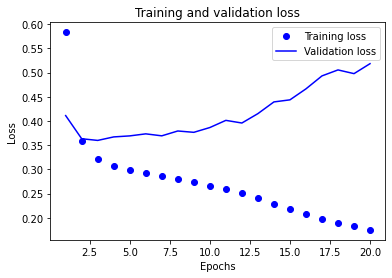

In [56]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

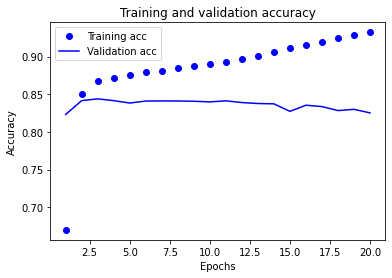

In [57]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

8) Word2Vec 임베딩 활용하여 성능 개선

In [58]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [59]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [60]:
os.getcwd()

'/aiffel/aiffel'

In [61]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

RNN

In [63]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv1D(8, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))





model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 16)             64        
_________________________________________________________________
dropout (Dropout)            (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 8)              904       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                

In [64]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
189/189 [==============================] - 4s 12ms/step - loss: 0.6134 - accuracy: 0.6467 - val_loss: 0.5257 - val_accuracy: 0.7697
Epoch 2/20
189/189 [==============================] - 2s 9ms/step - loss: 0.4226 - accuracy: 0.8102 - val_loss: 0.4115 - val_accuracy: 0.8191
Epoch 3/20
189/189 [==============================] - 2s 9ms/step - loss: 0.3603 - accuracy: 0.8473 - val_loss: 0.3758 - val_accuracy: 0.8329
Epoch 4/20
189/189 [==============================] - 2s 10ms/step - loss: 0.3236 - accuracy: 0.8663 - val_loss: 0.3810 - val_accuracy: 0.8328
Epoch 5/20
189/189 [==============================] - 2s 9ms/step - loss: 0.2895 - accuracy: 0.8840 - val_loss: 0.4014 - val_accuracy: 0.8273
Epoch 6/20
189/189 [==============================] - 2s 10ms/step - loss: 0.2686 - accuracy: 0.8934 - val_loss: 2.2641 - val_accuracy: 0.5199
Epoch 7/20
189/189 [==============================] - 2s 9ms/step - loss: 0.2468 - accuracy: 0.9046 - val_loss: 0.5327 - val_accuracy: 0.7867
Epo

In [65]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9788 - accuracy: 0.7591
[0.9787881374359131, 0.7590984106063843]


RNN 모델

In [90]:
# 모델 구성
from tensorflow.keras.layers import Bidirectional

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.4))

model.add(Bidirectional(tf.keras.layers.LSTM(16)))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 41, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                40576     
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 3,040,849
Trainable params: 3,040,849
Non-trainable params: 0
___________________________________________

In [91]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
189/189 [==============================] - 6s 17ms/step - loss: 0.6868 - accuracy: 0.5316 - val_loss: 0.5828 - val_accuracy: 0.7184
Epoch 2/20
189/189 [==============================] - 3s 14ms/step - loss: 0.5042 - accuracy: 0.7620 - val_loss: 0.3960 - val_accuracy: 0.8299
Epoch 3/20
189/189 [==============================] - 3s 14ms/step - loss: 0.4181 - accuracy: 0.8200 - val_loss: 0.3799 - val_accuracy: 0.8363
Epoch 4/20
189/189 [==============================] - 3s 14ms/step - loss: 0.3874 - accuracy: 0.8368 - val_loss: 0.3661 - val_accuracy: 0.8432
Epoch 5/20
189/189 [==============================] - 3s 14ms/step - loss: 0.3655 - accuracy: 0.8464 - val_loss: 0.3565 - val_accuracy: 0.8476
Epoch 6/20
189/189 [==============================] - 3s 14ms/step - loss: 0.3505 - accuracy: 0.8541 - val_loss: 0.3528 - val_accuracy: 0.8468
Epoch 7/20
189/189 [==============================] - 3s 14ms/step - loss: 0.3379 - accuracy: 0.8593 - val_loss: 0.3466 - val_accuracy: 0.8503

In [92]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3595 - accuracy: 0.8549
[0.3594818115234375, 0.8548731803894043]


## 회고
* overfitting을 해결하기 위해서 Dropout 레이어, BatchNormalize 레이어, Bidirectional 레이어등을 사용하니까 원하는 accuracy에 도달할 수 있었습니다.
* 항상 느끼는 거지만 점수 넘기가 생각보다 힘들어요...
* 화이팅!!!